<center><font size = "10"> Week 11 - Network Stimulation II and Extracellular recordings<center>
<center><font size = "8">Home Work <center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 3
<br>Group member 1: Laura TESTA
<br>Group member 2: Alice ALBRECHT
<br>Group member 3: Clara LE DRAOULEC
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignments to be delivered by next Monday before 23:59.


# <font color= 'red'>Ex 1:</font> Network activity analysis 

<font size='3'> Load the five morphology reconstructions assigned to your group in week 7, using the class `Cell` defined in the tutorials. 
Connect the neurons with following weights:
- `w(Pyr - Pyr) = 1`
- `w(Pyr - Int) = 1`
- `w(Int - Pyr) = -0.01`
- `w(Int - Int) = -0.01`

<font size='3'>Add exponential synapses to random section of the basal dendrite of each cell (synapse `weight = 1.0` and `tau = 2`). Connect different Poisson spike trains to each of the exponential synapses. (you can use your spike trains from week 10 or from this weeks tutorial). Make sure to use realistic parameters. Run the simulation of 300 ms and show the voltage and spike plots neurons and Poisson input.

<font size='3'>Using the `elephant` library calculate:
    
<font size='3'>1. The spike trains features: MFR, ISI and CV. Visualize (box plots) and compare the features between the Poisson inputs and spike trains of the neurons. Do you see any difference? Explain your answer.

<font size='3'>2. Pairwise __correlation__ coefficients and __covariance__ between the pairs of 5 neurons. Explain the difference between __covariance__, __correlation__ and __coherence__. 

<font size='3'>Hint: Make sure to represent both spike trains in ms. For box plot visualization make sure you choose right range for your y-axis.

    
<font size='3'><font color= 'red'>[2.5pts]</font>

In [1]:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import random

# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

--No graphics will be displayed.


0.0

### Creation of the class cell

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        # morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(
            self
        )  # Notice this change to be able to instantiate several cells

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

## Instantiate different cells

In [3]:
Pyr1 = Cell("Pyr_01.swc", "Pyr1", "Pyr")
Pyr2 = Cell("Pyr_02.swc", "Pyr2", "Pyr")
Pyr3 = Cell("Pyr_03.swc", "Pyr3", "Pyr")
Int1 = Cell("Int_01.swc", "Int1", "Int")
Int2 = Cell("Int_02.swc", "Int2", "Int")

cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

In [4]:
for c in cells_Pyr:
    print(
        "%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.apic), len(c.dend), len(c.soma), len(c.axon))
    )
for c in cells_Int:
    print(
        "%s: %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.dend), len(c.soma), len(c.axon))
    )

Pyr1: 13 apical sections, 34 basal sections, 1 soma sections and 169 axon senctions
Pyr2: 115 apical sections, 61 basal sections, 1 soma sections and 170 axon senctions
Pyr3: 46 apical sections, 37 basal sections, 1 soma sections and 81 axon senctions
Int1: 21 basal sections, 1 soma sections and 526 axon senctions
Int2: 36 basal sections, 1 soma sections and 131 axon senctions


### Neurons connected with `weight = 1.0` and exponential synapses connected with `weight = 1.0` and `tau = 2 ms`

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=5,
    source_neurite="axon",
    target_sec=10,
    target_neurite="dend",
):
    rng = np.random.default_rng()

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section

    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight

    print(
        f"Connected cells {source.name} -> {target.name} with weight {weight} and delay {delay},\
        from {source_neurite}[{source_sec}] to {target_neurite}[{target_sec}]"
    )

    return netcon

In [6]:
# Connect neurons with a weight = 1.0 or -0.01 
netcons = []  # save the netcons in case we want to modify them later

##### w(Pyr-Pyr) = 1 #####
# Connect Pyr1 to Pyr2
nc = connect(Pyr1, Pyr2, weight=1.0)
netcons.append(nc)

# Connect Pyr2 to Pyr1
nc = connect(Pyr2, Pyr1, weight=1.0)
netcons.append(nc)

# Connect Pyr1 to Pyr3
nc = connect(Pyr1, Pyr3, weight=1.0)
netcons.append(nc)

# Connect Pyr3 to Pyr1
nc = connect(Pyr3, Pyr1, weight=1.0)
netcons.append(nc)

# Connect Pyr2 to Pyr3
nc = connect(Pyr2, Pyr3, weight=1.0)
netcons.append(nc)

# Connect Pyr3 to Pyr2
nc = connect(Pyr3, Pyr2, weight=1.0)
netcons.append(nc)


##### w(Pyr-Int) = 1 #####
# Connect Pyr1 to Int1
nc = connect(Pyr1, Int1, weight=1.0)
netcons.append(nc)

# Connect Pyr1 to Int2
nc = connect(Pyr1, Int2, weight=1.0)
netcons.append(nc)

# Connect Pyr2 to Int1
nc = connect(Pyr2, Int1, weight=1.0)
netcons.append(nc)

# Connect Pyr2 to Int2
nc = connect(Pyr2, Int2, weight=1.0)
netcons.append(nc)

# Connect Pyr3 to Int1
nc = connect(Pyr3, Int1, weight=1.0)
netcons.append(nc)

# Connect Pyr3 to Int2
nc = connect(Pyr3, Int2, weight=1.0)
netcons.append(nc)


##### w(Int-Pyr) = -0.01 #####
# Connect Int1 to Pyr1
nc = connect(Int1, Pyr1, weight=-0.01)
netcons.append(nc)

# Connect Int1 to Pyr2
nc = connect(Int1, Pyr2, weight=-0.01)
netcons.append(nc)

# Connect Int1 to Pyr3
nc = connect(Int1, Pyr3, weight=-0.01)
netcons.append(nc)

# Connect Int2 to Pyr1
nc = connect(Int2, Pyr1, weight=-0.01)
netcons.append(nc)

# Connect Int2 to Pyr2
nc = connect(Int2, Pyr2, weight=-0.01)
netcons.append(nc)

# Connect Int2 to Pyr3
nc = connect(Int2, Pyr3, weight=-0.01)
netcons.append(nc)


##### w(Pyr-Int) = -0.01 #####
# Connect Int1 to Int2
nc = connect(Int1, Int2, weight=-0.01)
netcons.append(nc)

# Connect Int2 to Int1
nc = connect(Int2, Int1, weight=-0.01)
netcons.append(nc)

Connected cells Pyr1 -> Pyr2 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr2 -> Pyr1 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr1 -> Pyr3 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr3 -> Pyr1 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr2 -> Pyr3 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr3 -> Pyr2 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr1 -> Int1 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr1 -> Int2 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr2 -> Int1 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr2 -> Int2 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected cells Pyr3 -> Int1 with weight 1.0 and delay 5,        from axon[5] to dend[10]
Connected 

In [8]:
# Place exponential synapses in random basal dendrite sections
# Exponential synapses with tau = 2

# Cell 1
sec1 = random.randint(0, len(Pyr1.dend) - 1)
synapse1 = h.ExpSyn(Pyr1.dend[sec1](0.5))
synapse1.tau = 2  # ms
print("Stimulus applied in basal section num %s of Pyr1" % sec1)

# Cell 2
sec2 = random.randint(0, len(Pyr2.dend) - 1)
synapse2 = h.ExpSyn(Pyr2.dend[sec2](0.5))
synapse2.tau = 2  # ms
print("Stimulus applied in basal section num %s of Pyr2" % sec2)

# Cell 3
sec3 = random.randint(0, len(Pyr3.dend) - 1)
synapse3 = h.ExpSyn(Pyr3.dend[sec3](0.5))
synapse3.tau = 2  # ms
print("Stimulus applied in basal section num %s of Pyr2" % sec3)

# Cell 4
sec4 = random.randint(0, len(Int1.dend) - 1)
synapse4 = h.ExpSyn(Int1.dend[sec4](0.5))
synapse4.tau = 2  # ms
print("Stimulus applied in basal section num %s of Int1" % sec4)

# Cell 5
sec5 = random.randint(0, len(Int2.dend) - 1)
synapse5 = h.ExpSyn(Int2.dend[sec5](0.5))
synapse5.tau = 2  # ms
print("Stimulus applied in basal section num %s of Int1" % sec5)

Stimulus applied in basal section num 1 of Pyr1
Stimulus applied in basal section num 1 of Pyr2
Stimulus applied in basal section num 14 of Pyr2
Stimulus applied in basal section num 0 of Int1
Stimulus applied in basal section num 20 of Int1


### Setup stimulator per cell

In [11]:
# Create stimulators for synapses
stims = []
stim_nc = []
synapses = [synapse1, synapse2, synapse3, synapse4, synapse5]
for syn in synapses:
    stim = h.VecStim()
    nc = h.NetCon(stim, syn)
    nc.weight[0] = 0.5  # In units of [nS] due to the gmax scaling factor in our .mod file
    stims.append(stim)
    stim_nc.append(nc)

### Setup stimulation times: Poissonian

In [12]:
import elephant.spike_train_generation as elstg
import quantities as pq

# Create a Poissonian spike train
stim_rate = 60 * pq.Hz
stim_tstart = 5 * pq.ms
stim_tstop = 300 * pq.ms

stim_times = []
for stim in stims:
    sptimes = elstg.homogeneous_poisson_process(
        stim_rate, stim_tstart, stim_tstop, as_array=True
    )
    spvec = h.Vector(sptimes)
    stim.play(spvec)  # make stimulator fire at these times
    stim_times.append(sptimes)
    print(sptimes)

[ 21.67212381  22.65879373  29.81425552  84.70232147 105.17886911
 140.40445097 183.69025159 191.58185372 199.62200546 204.34209298
 219.94436591 261.23832528 284.97085179]
[ 24.82424263  47.68456276  62.56087285  62.95991262 112.09126876
 116.21246631 153.6555529  154.84774862 172.03626613 172.83873842
 185.74561795 200.72406584 223.30172853 229.39223614 241.53698087
 244.4967991  254.88743292 263.15229197]
[ 68.28919951  98.72035326 120.87601611 131.69725311 161.27565014
 172.03635557 182.71157315 227.30889907 271.85908073 284.24647102]
[ 33.33161404  38.58530329  54.24469466  70.08065677  70.75214607
  75.12609336  81.68097464 115.80222007 125.55901635 129.91672895
 135.29520825 145.68342938 183.13969904 209.6716803  252.33202913
 260.64084983 263.40629623 266.41929121 268.96005781 283.8391951
 291.88253977]
[ 41.26568949  44.6673104   51.13270865  53.33908096  56.59883687
 114.94790386 138.76829366 145.45890841 157.56057903 174.05857356
 183.5412368  226.01169087 226.40009156 238.4

### Run simulation

In [15]:
recording_cells = [Pyr1, Pyr2, Pyr3, Int1, Int2]

somaV = []
for cell in recording_cells:
    s = h.Vector().record(cell.soma[0](0.5)._ref_v)
    somaV.append(s)

time = h.Vector().record(h._ref_t)
sim_tstop = 300

h.finitialize(-65)
h.continuerun(sim_tstop)

0.0

### Plot voltage traces

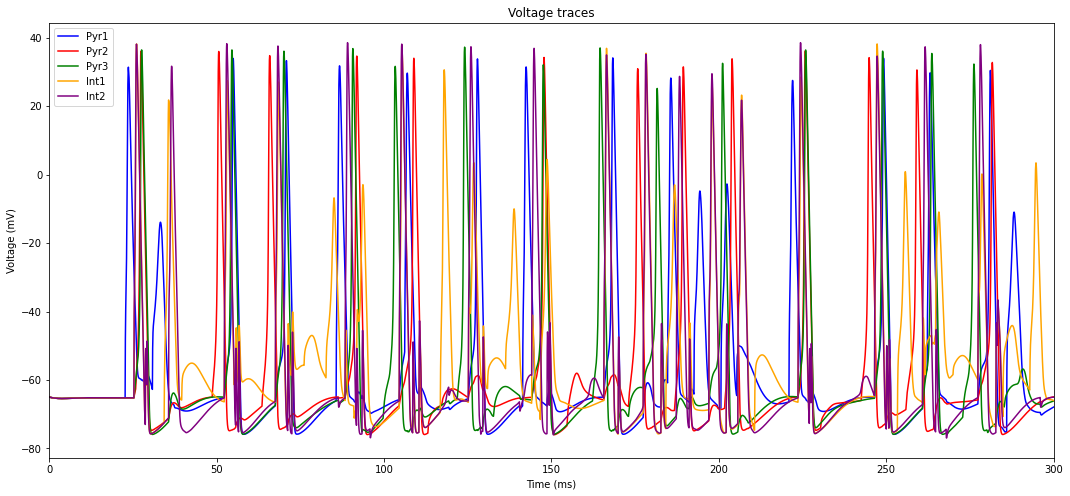

In [78]:
colors = ["blue", "red", "green", "orange", "purple"]

fig, ax = plt.subplots(figsize=(18, 8))
for cell, V, color in zip(recording_cells, somaV, colors):
    ax.plot(time, V, label=cell.name, color=color)

ax.set_xlim((0, sim_tstop))
ax.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage traces')
plt.show()

### Spike detection

In [24]:
from neo import AnalogSignal


def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to neo.AnalogSignal
    sig = AnalogSignal(
        voltage, units=pq.mV, sampling_period=0.025 * pq.ms
    )  # dt = 0.025 ms
    # peak locations
    spike_time = elstg.peak_detection(sig, threshold=threshold * pq.mV, format="raw")
    return spike_time * 1000  # in ms

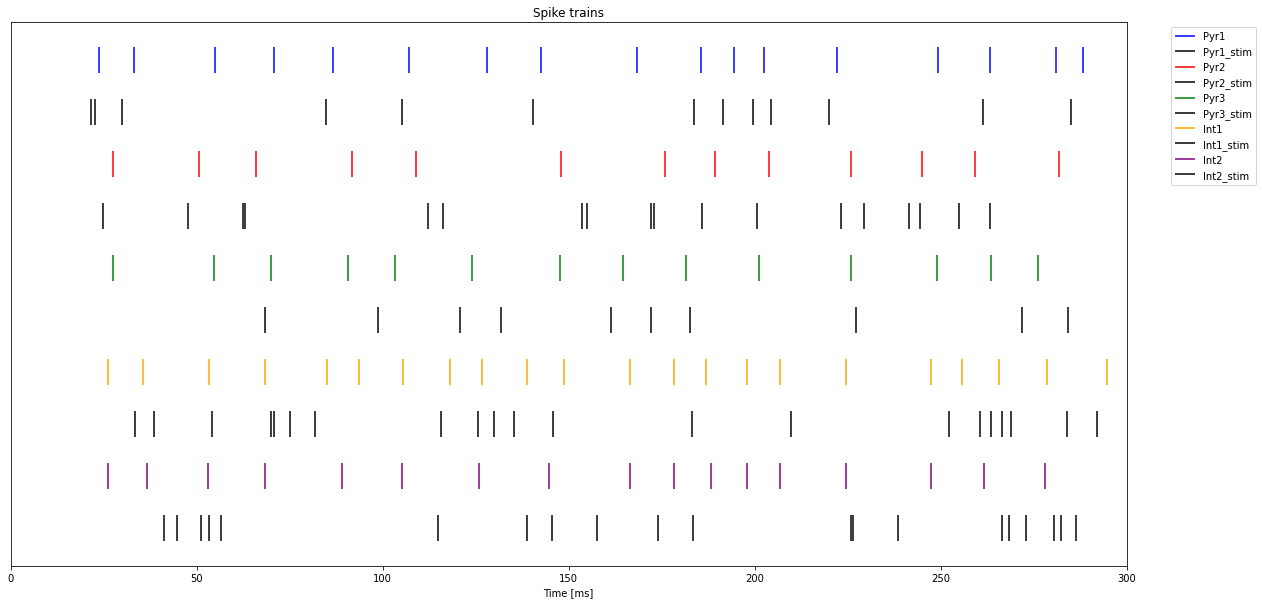

In [79]:
spike_trains = []
for V, st in zip(somaV, stim_times):
    spk = spike_detector(V, -20.0)  # tune threshold as needed
    spike_trains.append(spk)  # add cell spikes
    spike_trains.append(st)  # add stim spikes

name_lst = [[_.name, _.name + "_stim"] for _ in recording_cells]
name_lst = [x for sub in name_lst for x in sub]  # https://stackoverflow.com/a/952952

colors = ["blue", "black", "red", "black", "green", "black", "orange", "black", "purple", "black"]

fig, ax = plt.subplots(figsize=(20, 10))
for (i, name), spikes, color in zip(enumerate(name_lst), spike_trains, colors):
    ymin = 2 * i * -0.1
    ymax = 2 * i * -0.1 - 0.1
    ax.vlines(spikes, ymin=ymin, ymax=ymax, color=color, label=name)

ax.set_xlim((0, sim_tstop))
ax.set_xlabel("Time [ms]")
ax.set_yticks([])

# Put a legend below current axis
ax.legend(bbox_to_anchor=(1.12, 1))

plt.title('Spike trains')
plt.show()

## 1. Single Spike train statistics

In [46]:
import elephant.statistics as elstat

cell_MFR = []
cell_CV_of_ISI = []
poisson_MFR = []
poisson_CV_of_ISI = []

for x, s in zip(name_lst, spike_trains):
    print(x)
    fr = elstat.mean_firing_rate(s) * 1000
    print("Mean firing rate = %g Hz" % fr)
    # Inter-spike intervals
    isi = elstat.isi(s)
    cv = elstat.cv(isi)
    print("CV of ISI = %g" % cv)
    if name_lst.index(x) % 2 == 0 :
        cell_MFR.append(fr)
        cell_CV_of_ISI.append(cv)
    else :
        poisson_MFR.append(fr)
        poisson_CV_of_ISI.append(cv)

Pyr1
Mean firing rate = 58.9868 Hz
CV of ISI = 0.356184
Pyr1_stim
Mean firing rate = 45.6187 Hz
CV of ISI = 0.776407
Pyr2
Mean firing rate = 46.1525 Hz
CV of ISI = 0.332376
Pyr2_stim
Mean firing rate = 68.4015 Hz
CV of ISI = 0.916017
Pyr3
Mean firing rate = 50.6879 Hz
CV of ISI = 0.233865
Pyr3_stim
Mean firing rate = 35.1807 Hz
CV of ISI = 0.552845
Int1
Mean firing rate = 74.6459 Hz
CV of ISI = 0.305206
Int1_stim
Mean firing rate = 71.9467 Hz
CV of ISI = 0.94171
Int2
Mean firing rate = 61.1181 Hz
CV of ISI = 0.280415
Int2_stim
Mean firing rate = 69.8255 Hz
CV of ISI = 1.16064


#### Visualize (box plots) and compare the features between the Poisson inputs and spike trains of the neurons. Do you see any difference? Explain your answer. 

DITES MOI SI VOUS PREFEREZ SUR DES PLOTS DIFFERENTS OU SUR SEULEMENT 2 PLOTS, ET AUSSI JE SAIS PAS SI JE DOIS GROUPER OU NON TOUTES LES CELLULES

In [40]:
cell_names = [x for i, x in enumerate(name_lst) if i % 2 == 0]
cell_spikes = [x for i, x in enumerate(spike_trains) if i % 2 == 0]
poisson_names = [x for i, x in enumerate(name_lst) if i % 2 == 1]
poisson_spikes = [x for i, x in enumerate(spike_trains) if i % 2 == 1]

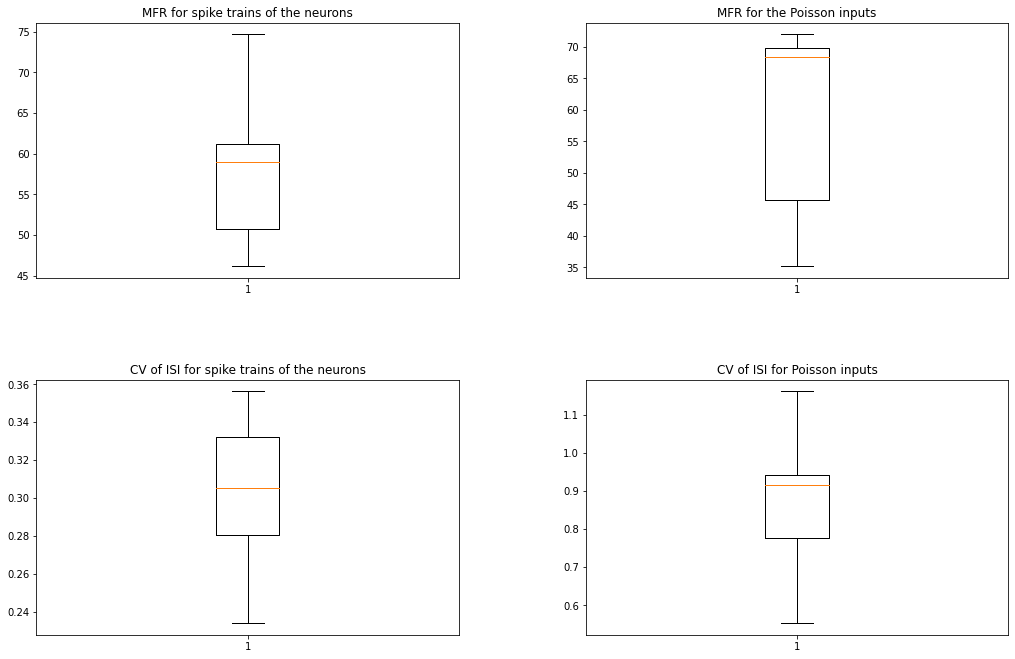

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0, 0].boxplot(cell_MFR)
axs[0, 0].set_title('MFR for spike trains of the neurons')

axs[0, 1].boxplot(poisson_MFR)
axs[0, 1].set_title('MFR for the Poisson inputs')

axs[1, 0].boxplot(cell_CV_of_ISI)
axs[1, 0].set_title('CV of ISI for spike trains of the neurons')

axs[1, 1].boxplot(poisson_CV_of_ISI)
axs[1, 1].set_title('CV of ISI for Poisson inputs')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
plt.show()

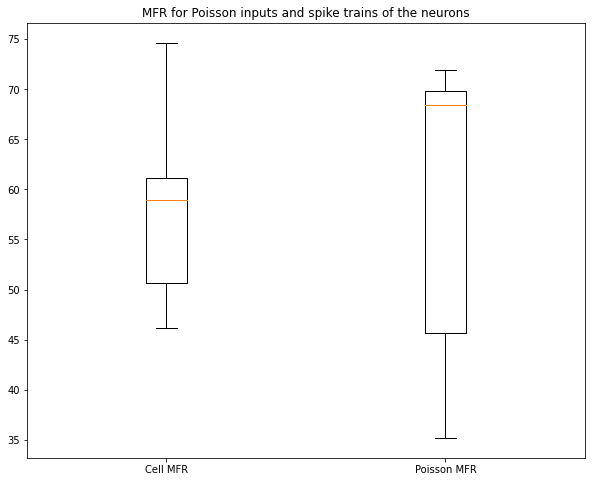

In [71]:
data = [cell_MFR, poisson_MFR]

fig, ax = plt.subplots(figsize = (10,8))
ax.boxplot(data)

plt.xticks([1, 2], ['Cell MFR', 'Poisson MFR'])
plt.title('MFR for Poisson inputs and spike trains of the neurons')
plt.show()

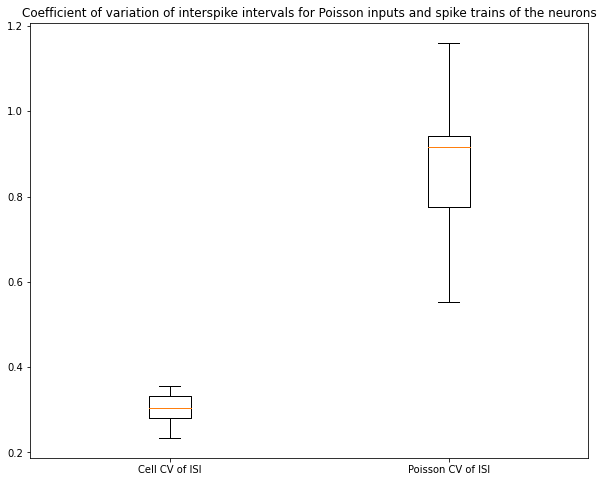

In [72]:
data2 = [cell_CV_of_ISI, poisson_CV_of_ISI]

fig, ax = plt.subplots(figsize = (10,8))
ax.boxplot(data2)

plt.xticks([1, 2], ['Cell CV of ISI', 'Poisson CV of ISI'])
plt.title('Coefficient of variation of interspike intervals for Poisson inputs and spike trains of the neurons')
plt.show()

## 2. Correlation analysis between spike trains

In [33]:
from neo import SpikeTrain
from elephant.conversion import BinnedSpikeTrain
import elephant.spike_train_correlation as elstc

### Pairwise correlation histograms

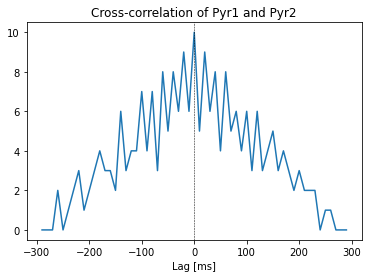

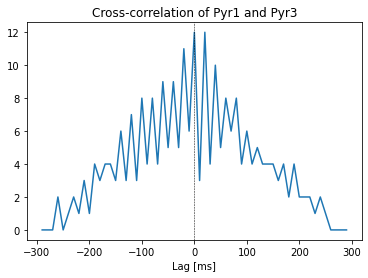

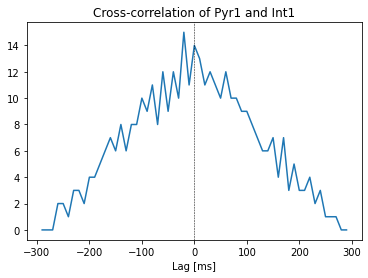

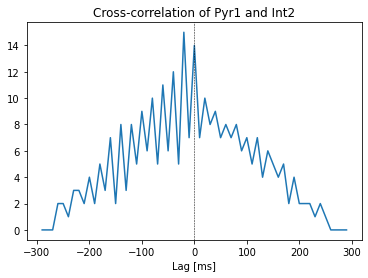

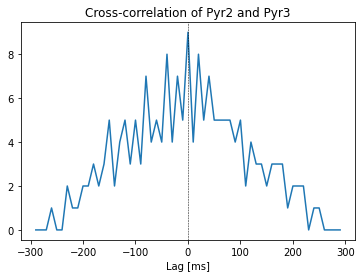

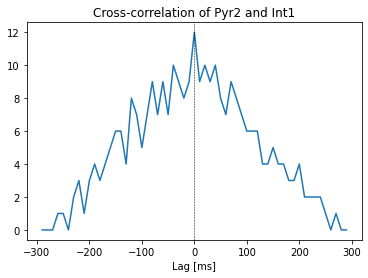

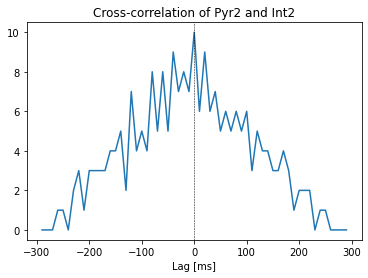

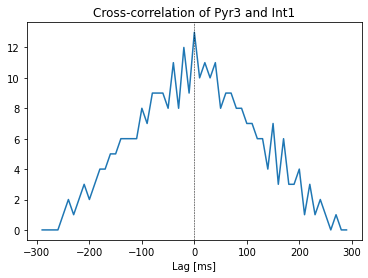

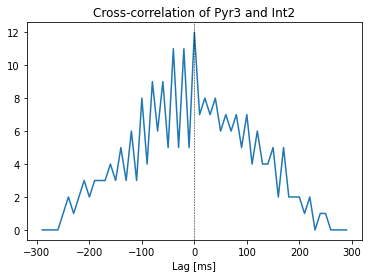

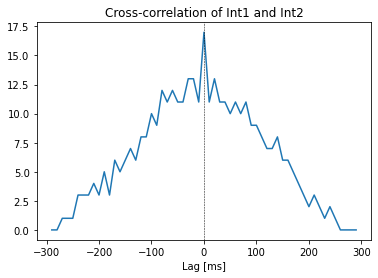

In [73]:
import itertools

# Pick only cell spike trains (saved in even entries of spike_trains)
cell_names = [x for i, x in enumerate(name_lst) if i % 2 == 0]
cell_spikes = [x for i, x in enumerate(spike_trains) if i % 2 == 0]

binsize = 10 * pq.ms  # 10 ms bin
allspikes = [SpikeTrain(x * pq.ms, t_stop=sim_tstop * pq.ms) for x in cell_spikes]
binned_spikes = [BinnedSpikeTrain(x, binsize=binsize) for x in allspikes]

for a, b in itertools.combinations(zip(cell_names, binned_spikes), 2):
    cch, lags = elstc.cross_correlation_histogram(a[1], b[1], border_correction=False)
    fig, ax = plt.subplots()
    ax.set_title("Cross-correlation of {} and {}".format(a[0], b[0]))
    ax.set_xlabel("Lag [ms]")
    plt.plot(lags * binsize, cch)
    plt.axvline(0, ls="--", color="black", lw=0.5)

### Pairwise correlation coefficients

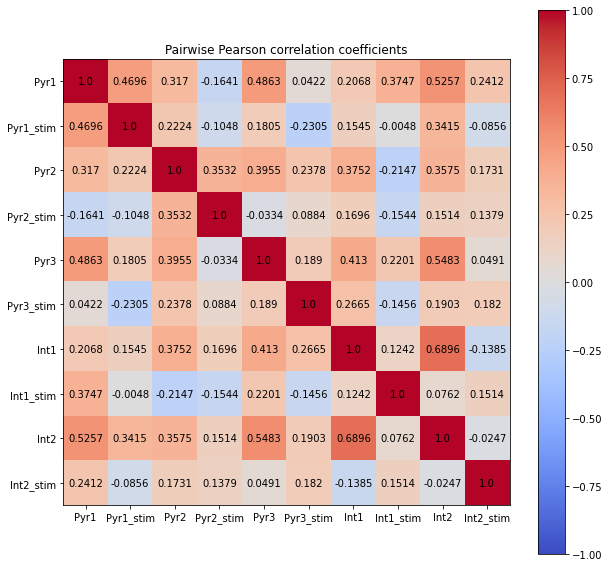

In [74]:
# We bin the spikes in both cell and stim spikes
allspikes = [SpikeTrain(x * pq.ms, t_stop=sim_tstop * pq.ms) for x in spike_trains]
binned_spikes = BinnedSpikeTrain(allspikes, binsize=10 * pq.ms)  # 10 ms bin
# Correlation coefficient matrix between all spike trains
cc = elstc.corrcoef(binned_spikes)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cc, cmap="coolwarm", vmin=-1.0, vmax=1.0, origin="upper")

# We want to show all ticks...
ax.set_xticks(np.arange(len(name_lst)))
ax.set_yticks(np.arange(len(name_lst)))
# ... and label them with the respective list entries
ax.set_xticklabels(name_lst)
ax.set_yticklabels(name_lst)

# Loop over data dimensions and create text annotations.
for i in range(len(name_lst)):
    for j in range(len(name_lst)):
        text = ax.text(
            j, i, np.round(cc[i, j], 4), ha="center", va="center", color="black"
        )

ax.set_title("Pairwise Pearson correlation coefficients")
plt.colorbar(im)
plt.show()

Covariance explains how much two variables differ, whereas correlation is used to measure the strength of the relationship between two continuous variables and is normalized between -1 and 1.
The correlation can be seen as a normalization of the covariance. They both indicate the direction of the linear relationship of two variables but as correlation is normalized, it also indicates the strength of this relationship. 

Coherence measures the quality of the information between two variables, meaning how much the data are logically connected and complete. It also describes the linear relationship between two variables but is less sensitive to noise and more robust.

# <font color= 'red'>Ex 2:</font> Extracelullar response to the synaptic input 

<font size='3'> Choose one pyramidal and one inihibitory cell models from your set of morphologies. Perform the stimulation protocol from tutorial 3. Make sure to correct for the rotation angles, as the cell needs to be aligned with the electrode line. 

<font size='3'>Explain what do you see on the final plots. Are there differences between the two neurons?
    
<font size='3'><font color= 'red'>[1.5 pts]</font>

# <font color= 'red'>Ex 3:</font> Extracellular field

<font size='3'>Choose one pyramidal cell and one inhibitory cell from your set of cells. Run the code from tutorial 04 for each of the cells and compare the resulted response field for each of them. Explain what differences do you see and why.

<font size='3'><font color= 'red'>[2 pts]</font>   